# Temperature dependence of CsI crystals

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

from crysp import crysp

In [2]:
mpl.rcParams.update({
    "font.family": "serif",
    "axes.titlesize": "xx-large",
    "axes.labelsize": "xx-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "legend.fontsize": "large",
    "legend.frameon": False,
    "text.usetex": True
})

## Gain dependence
Here we plot the single photoelectron charge as a function of the temperature. As expected, at a fixed voltage, the SPE charge decreases when the temperature increases, since warming the SiPM means increasing the breakdown voltage.

  0%|          | 0/10 [00:00<?, ?it/s]

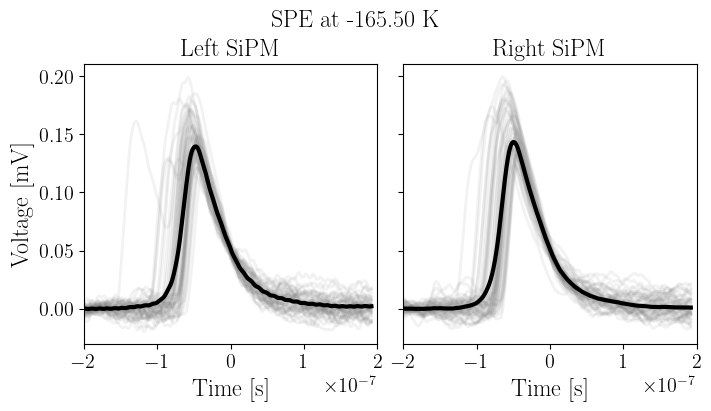

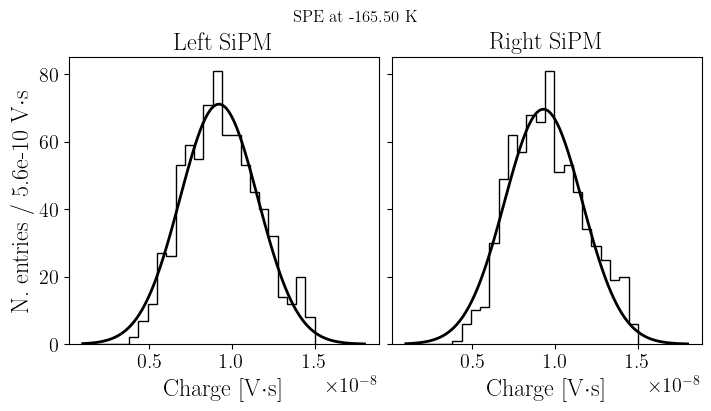

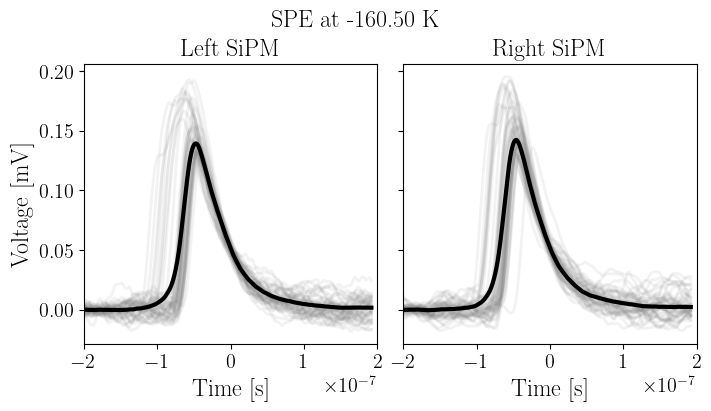

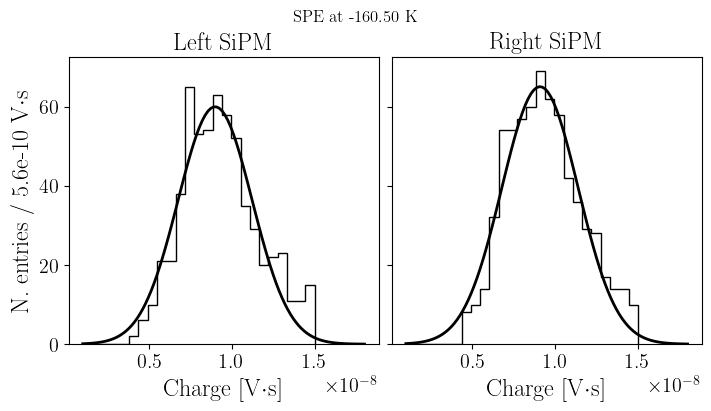

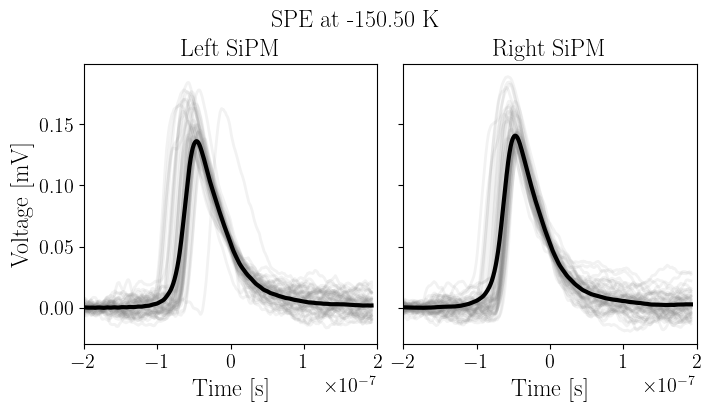

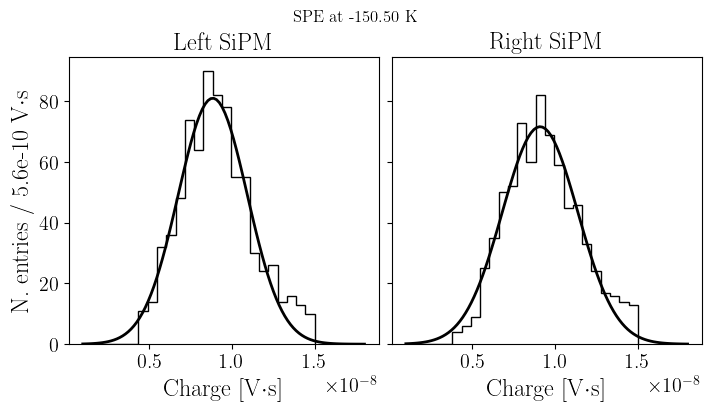

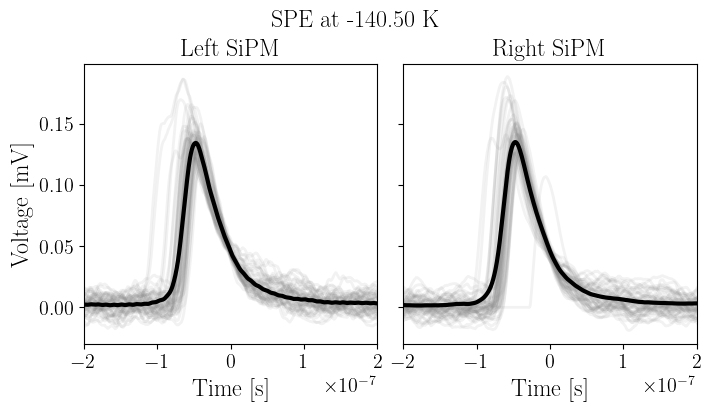

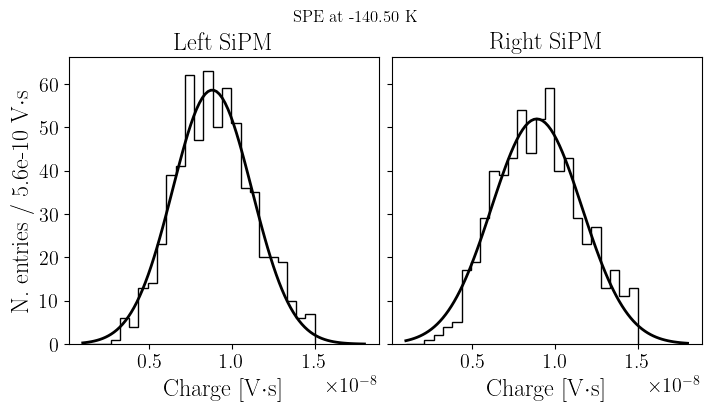

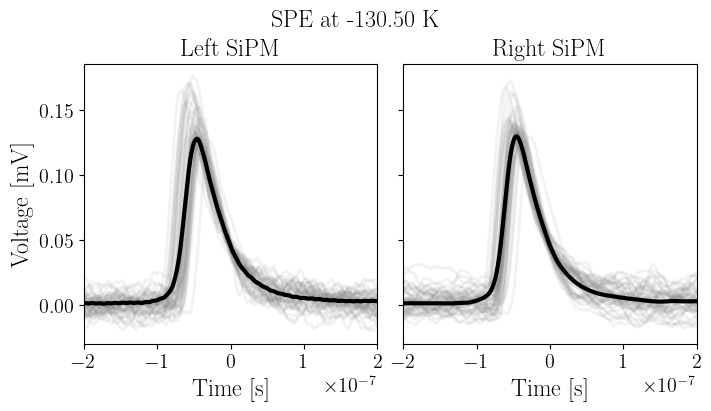

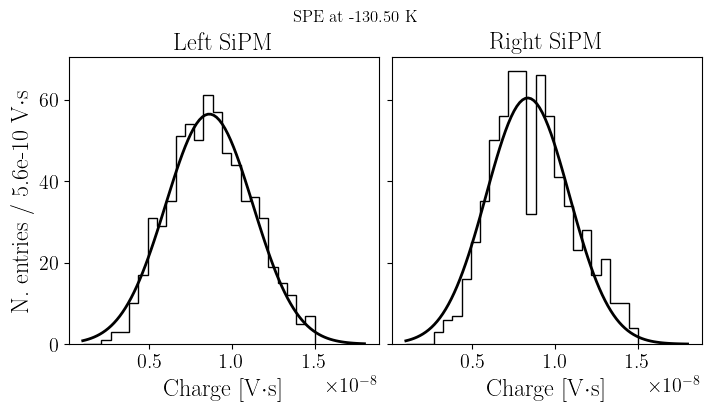

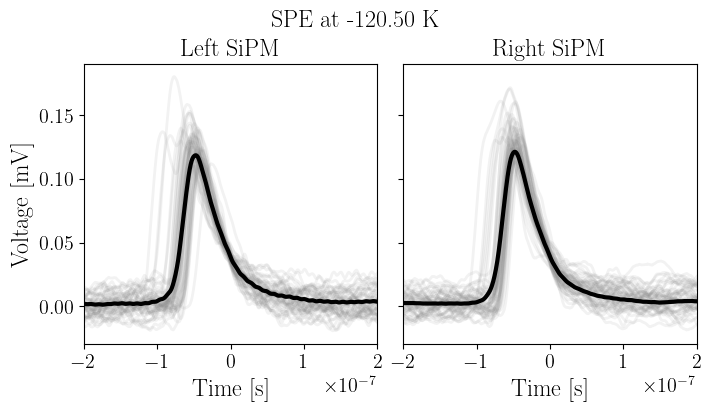

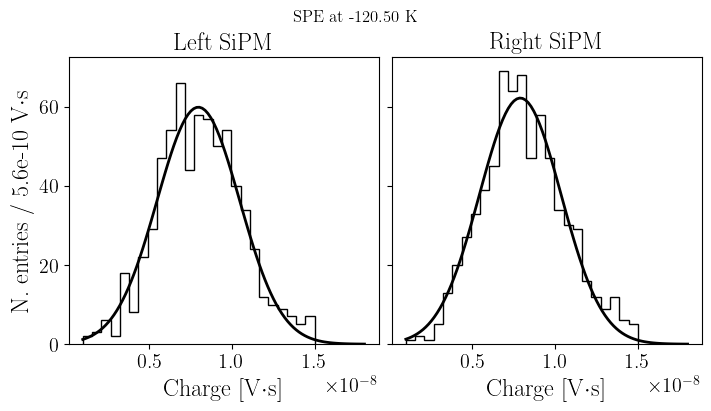

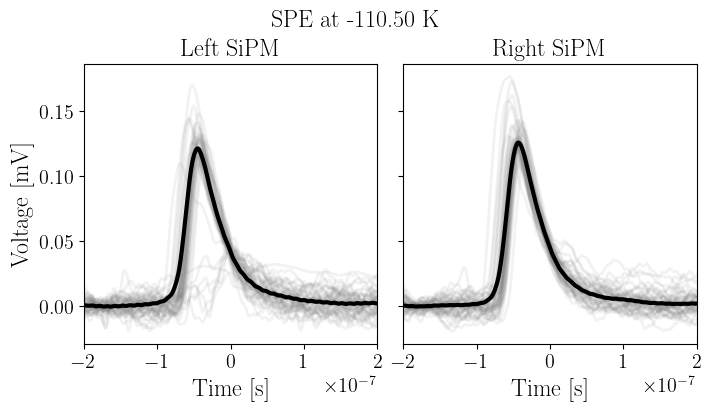

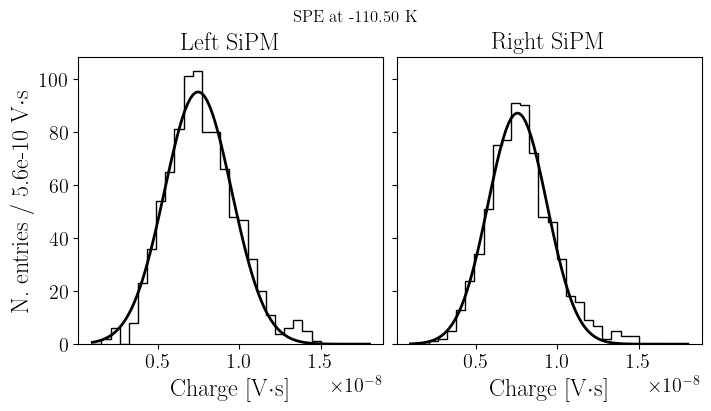

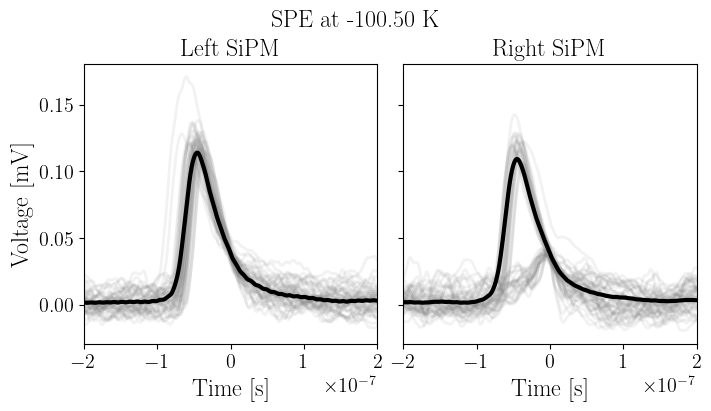

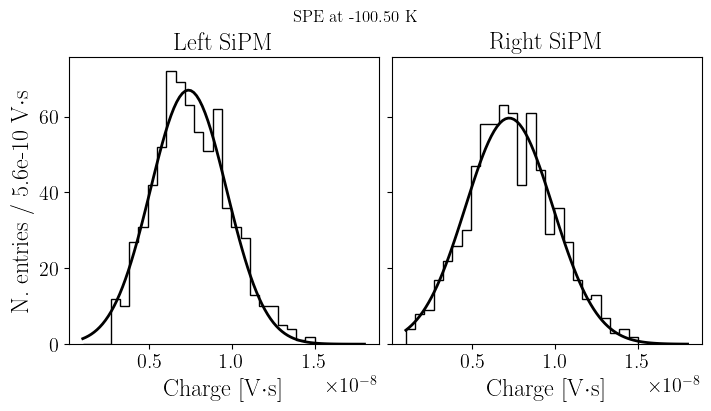

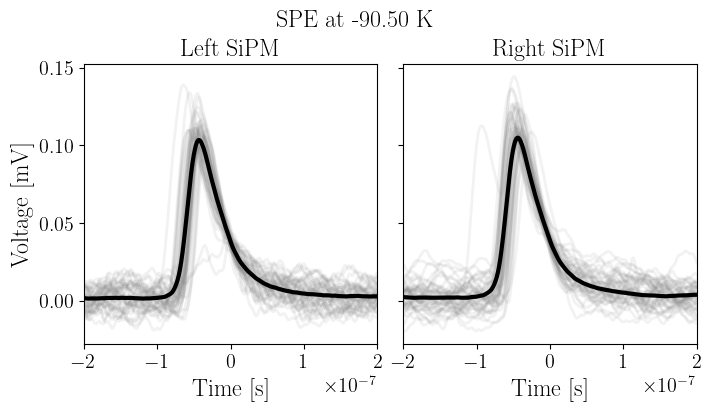

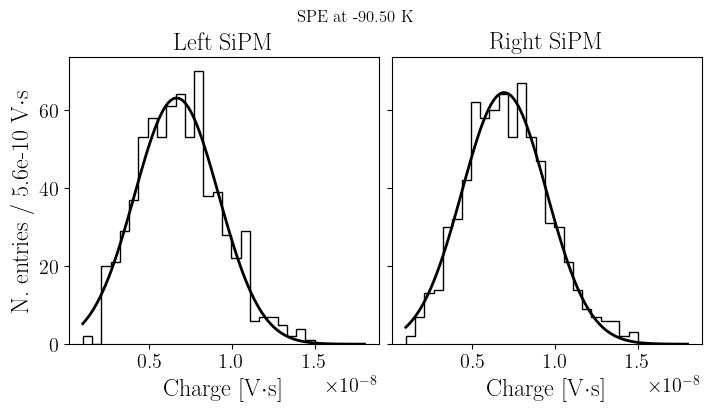

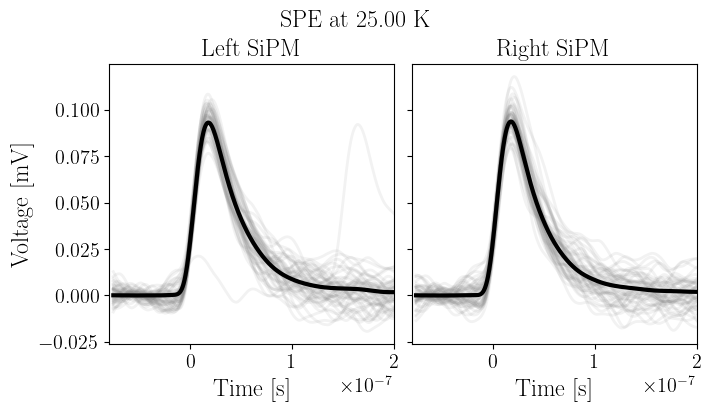

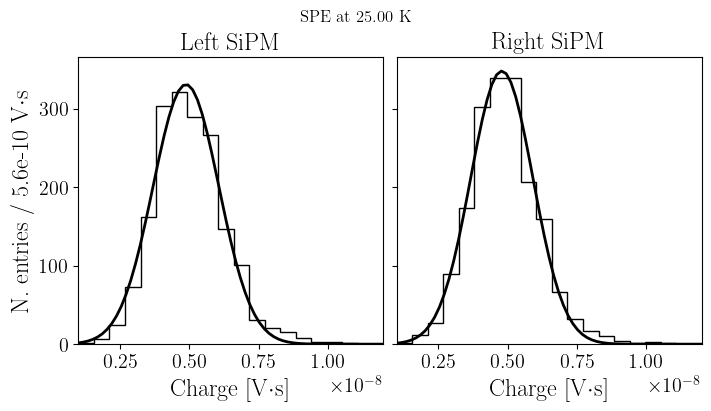

In [3]:
temps = np.array(
    [-165.5, -160.5, -150.5, -140.5, -130.5, -120.5, -110.5, -100.5, -90.5, 25]
)


gains_left = []
gains_right = []
gains_right_err = []
gains_left_err = []

for temp in tqdm(temps):
    time_right, right = crysp.read_single_crystal(f"data/right_{abs(temp):.1f}.zip")
    time_left, left = crysp.read_single_crystal(f"data/left_{abs(temp):.1f}.zip")

    left, average_left = crysp.baseline_subtract(time_left, left, top=0.2)
    right, average_right = crysp.baseline_subtract(time_right, right, top=0.2)
    integration_range = (time_left > -2e-7) & (time_left < 2e-7)

    fig, ax = plt.subplots(
        1, 2, constrained_layout=True, sharex=True, sharey=True, figsize=(7, 4)
    )
    _ = ax[0].plot(time_left, left[:50, :].T, alpha=0.1, c="gray")
    _ = ax[0].plot(time_left, average_left, c="k", lw=3)
    ax[0].set_xlim(-2e-7, 2e-7)
    if temp == temps[-1]:
        ax[0].set_xlim(-0.8e-7, 2e-7)

    _ = ax[1].plot(time_right, right[:50, :].T, alpha=0.1, c="gray")
    _ = ax[1].plot(time_right, average_right, c="k", lw=3)

    ax[0].set_xlabel("Time [s]", fontsize='xx-large')
    ax[1].set_xlabel("Time [s]")
    ax[0].set_ylabel("Voltage [mV]")
    ax[0].set_title("Left SiPM")
    ax[1].set_title("Right SiPM")

    fig.suptitle(f"SPE at {temp:.2f} K", fontsize="xx-large")

    fig, ax = plt.subplots(
        1, 2, constrained_layout=True, sharex=True, sharey=True, figsize=(7, 4)
    )
    n_left, bins, patches = ax[0].hist(
        np.trapz(left[:, integration_range], x=time_left[integration_range], axis=1),
        bins=25,
        histtype="step",
        color="k",
        range=(0.1e-8, 1.5e-8),
    )
    n_right, bins, patches = ax[1].hist(
        np.trapz(right[:, integration_range], x=time_right[integration_range], axis=1),
        bins=25,
        histtype="step",
        range=(0.1e-8, 1.5e-8),
        color="k",
    )
    bin_centers = (bins[:-1] + bins[1:]) / 2
    p_left, pcov_left = curve_fit(crysp.gauss, bin_centers, n_left, p0=(50, 1e-8, 0.5e-8))
    gains_left_err.append(np.sqrt(np.diag(pcov_left))[1])
    xx = np.linspace(0.1e-8, 1.8e-8, 100)
    ax[0].plot(xx, crysp.gauss(xx, *p_left), c="k")
    p_right, pcov_right = curve_fit(crysp.gauss, bin_centers, n_right, p0=(50, 1e-8, 0.5e-8))
    gains_right_err.append(np.sqrt(np.diag(pcov_right))[1])
    ax[1].plot(xx, crysp.gauss(xx, *p_right), c="k")
    fig.suptitle(f"SPE at {temp:.2f} K")
    ax[0].set_ylabel(
        f"N. entries / {bins[1]-bins[0]:.1e} V$\cdot$s"
    )
    ax[0].set_xlabel("Charge [V$\cdot$s]")
    ax[1].set_xlabel("Charge [V$\cdot$s]")
    ax[0].set_title("Left SiPM")
    ax[1].set_title("Right SiPM")
    if temp == temps[-1]:
        ax[0].set_xlim(0.1e-8, 1.2e-8)
    gains_left.append(p_left[1])
    gains_right.append(p_right[1])

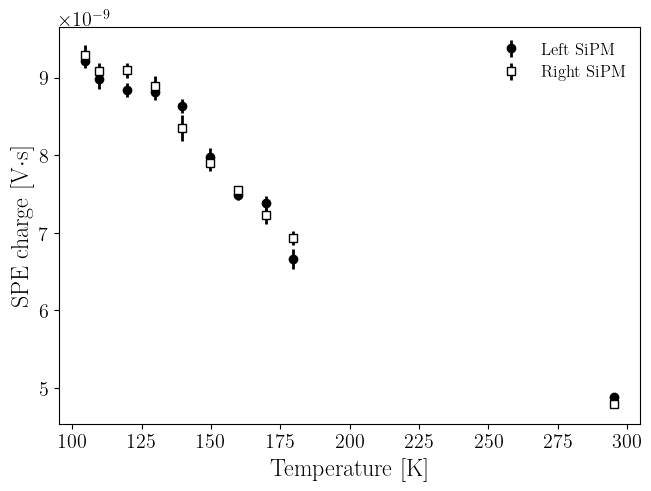

In [4]:
fig, ax = plt.subplots(1,1, constrained_layout=True)
temps_label = temps + 273.15-3
ax.errorbar(temps_label, gains_left, gains_left_err, fmt='ko', label='Left SiPM')
ax.errorbar(temps_label, gains_right, gains_right_err, fmt='ks', markerfacecolor='w', label='Right SiPM')
ax.set_ylabel(f"SPE charge [V$\cdot$s]")
ax.set_xlabel("Temperature [K]")
ax.legend(frameon=False)

## Light yield
Here we calculate the light yield of the two crystals as a function of the temperature. Undoped CsI emit an order of magnitude more light when cooled at liquid nitrogen temperature. 

  0%|          | 0/10 [00:00<?, ?it/s]

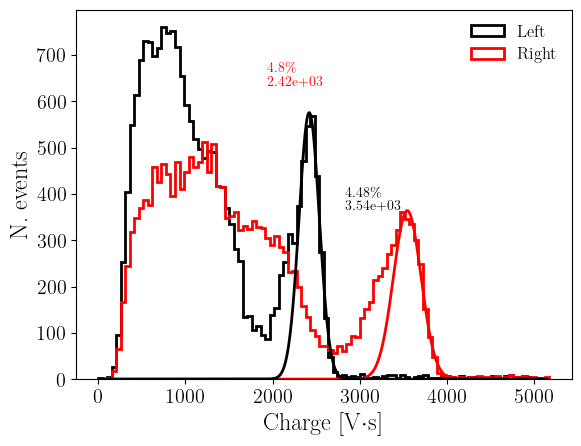

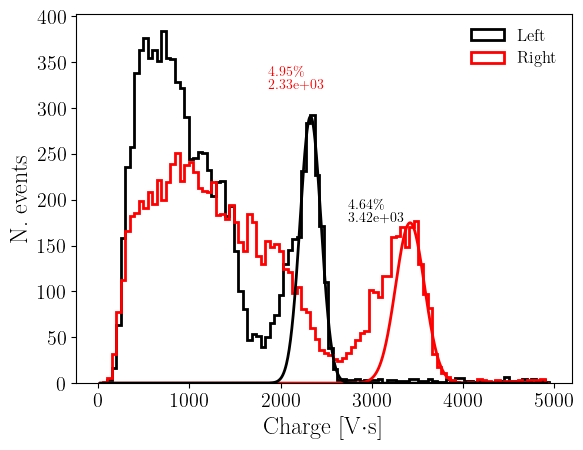

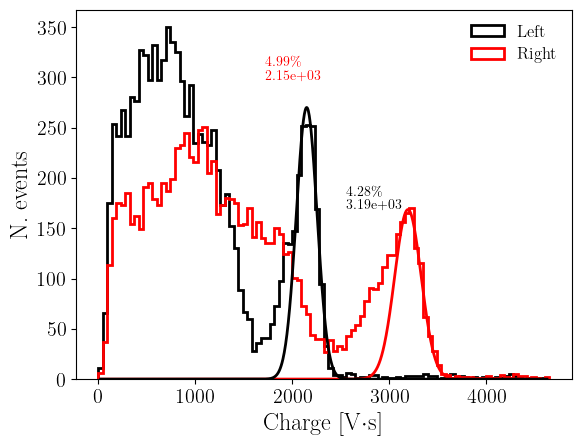

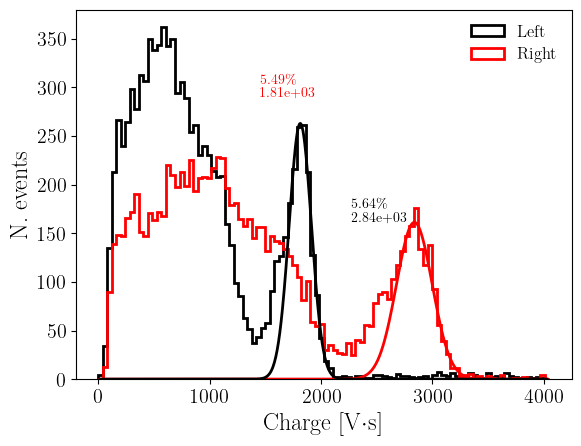

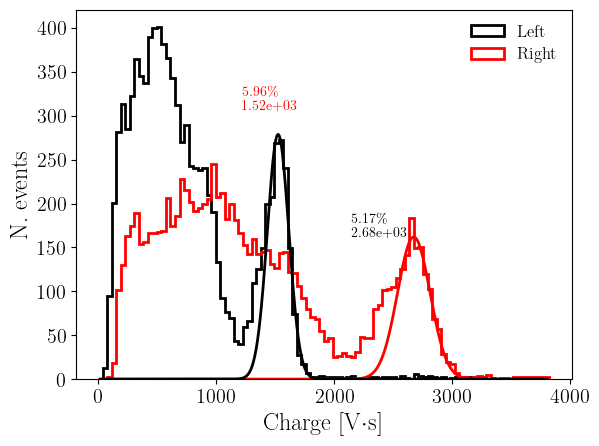

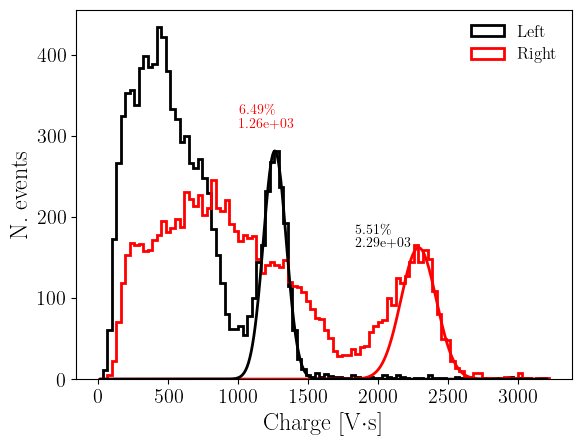

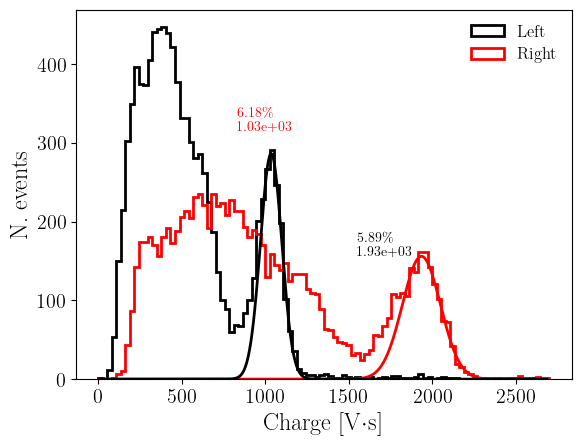

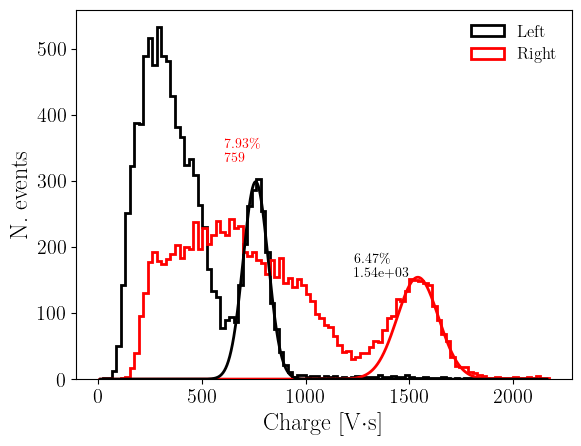

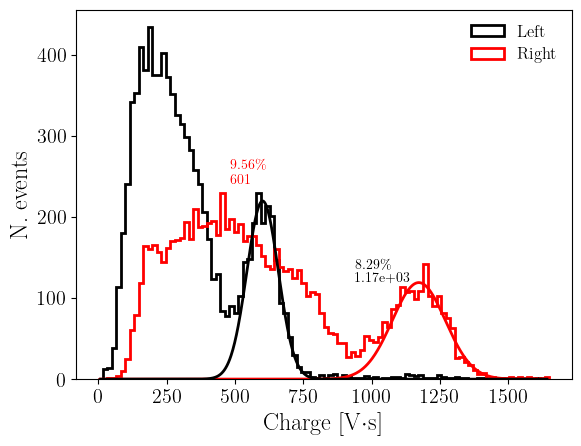

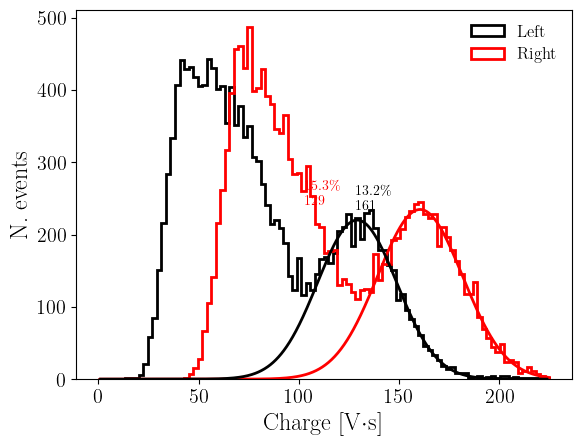

In [5]:
starts_left = [2300, 2200, 2000, 1700, 1400, 1150, 1000, 650, 550, 110]
starts_right = [3450, 3300, 3100, 2700, 2550, 2150, 1800, 1450, 1100, 150]

peaks = []
peaks_right = []
sigmas = []
errs = []
errs_right = []
averages_left = []
averages_right = []
times = []

for i,temp in enumerate(tqdm(temps)):
    time_temp, left_temp, right_temp = crysp.read_file(f"data/na22_{abs(temp)}.zip")
    if i == 3:
        fig, ax, average_left, average_right, peak_left, sigma_left, left_err, peak_right, sigma_right, right_err = crysp.plot_spectra(time_temp, right_temp, left_temp, gains_left[i]/880, gains_right[i]/880, starts_left[i], starts_right[i])
    else:
        fig, ax, average_left, average_right, peak_left, sigma_left, left_err, peak_right, sigma_right, right_err = crysp.plot_spectra(time_temp, left_temp, right_temp, gains_left[i]/880, gains_right[i]/880, starts_left[i], starts_right[i])

    peaks.append(peak_left)
    peaks_right.append(peak_right)
    sigmas.append(sigma_left)
    errs.append(left_err)
    errs_right.append(right_err)
    averages_left.append(average_left)
    averages_right.append(average_right)
    times.append(time_temp)


Text(0.5, -1.3885555555555573, 'Temperature [K]')

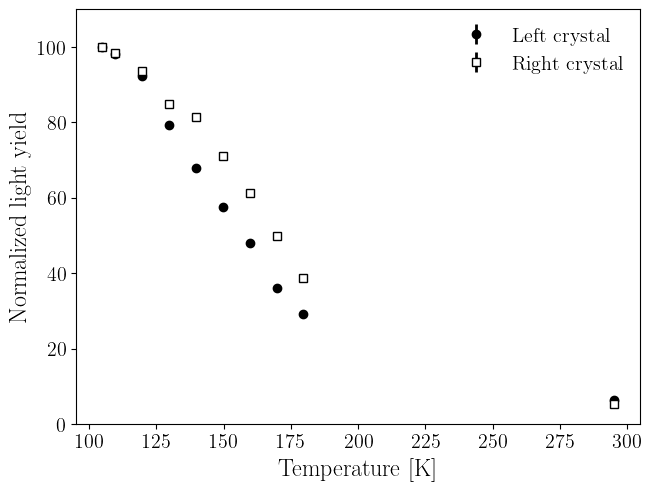

In [6]:
fig, ax = plt.subplots(1,1,constrained_layout=True)

ly = np.array(peaks)/np.linspace(0.18, 0.15, len(temps))
ly_right = np.array(peaks_right)/np.linspace(0.18, 0.15, len(temps))

ax.errorbar(temps_label, ly/max(ly)*100 , fmt='ko', yerr=np.array(errs)[:,1]/max(ly)*100, label='Left crystal')
ax.errorbar(temps_label, ly_right/max(ly_right)*100 , fmt='ks', markerfacecolor='w', yerr=np.array(errs_right)[:,1]/max(ly)*100, label='Right crystal')

ax.set_ylim(0,110)
ax.set_xlim(95, 305)
ax.legend(frameon=False,fontsize='x-large')
fig.savefig("peaks.png", transparent=True)
ax.set_ylabel("Normalized light yield", fontsize='xx-large')
ax.set_xlabel("Temperature [K]", fontsize='xx-large')


## Decay time
Undoped CsI crystals have a light emission time constant that increases when the temperature decreases. A fast component appears at approximately 140 K. We also observe a slower component not present in the literature

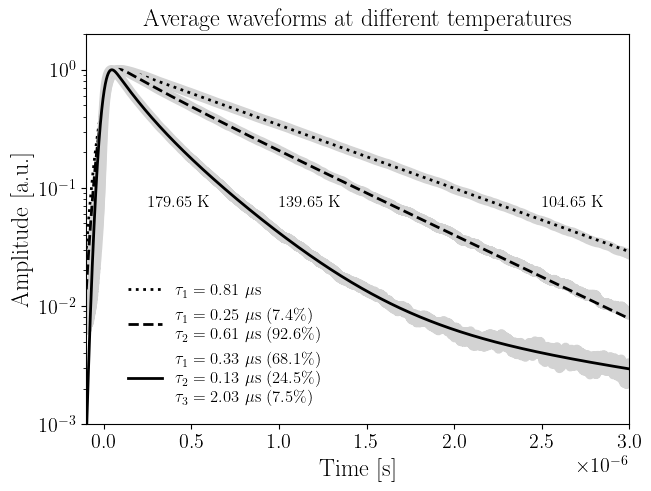

In [7]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
start_fit = 0.015e-6
taus = []
taus_2 = []
taus_3 = []
taus_err = []
taus_err_2 = []
for i, average in enumerate(averages_left):
    normalized_average = average / max(average)
    time = times[i]
    if i in [0, 4, 8]:
        ax.plot(time, normalized_average, lw=7, color="lightgray")

    if i < 4:
        p_t, pcov_t = curve_fit(
            crysp.exp_gauss,
            time[time > start_fit],
            normalized_average[time > start_fit],
            p0=(1e-6, 0.5e-8, 1.23e6, 1e-7),
        )
        if i == 0:
            ax.plot(
                time[time > -0.2e-6],
                crysp.exp_gauss(time[time > -0.2e-6], *p_t),
                c="k",
                ls=":",
                label=rf"""$\tau_1={1/p_t[2]*1e6:.2f}$ $\mu$s""",
            )
            ax.text(2.5e-6, 0.7e-1, f"{temps_label[i]:.2f} K", fontsize="large")

        taus.append(1 / p_t[2])
        taus_err.append(np.sqrt(np.diag(pcov_t))[2] / p_t[2])
    elif 4 <= i < 6:
        p_t2, pcov_t2 = curve_fit(
            crysp.two_exp_gauss,
            time[time > start_fit],
            normalized_average[time > start_fit],
            p0=(1e-6, 0.5, 0.5e-8, 6e6, 2e6, 1e-7),
            bounds=((0, 0, 0, 4e6, 0.1e6, 0), (1, 1, 1e-6, 1e7, 1e7, 1)),
        )
        if i == 4:
            ax.plot(
                time[time > -0.2e-6],
                crysp.two_exp_gauss(time[time > -0.2e-6], *p_t2),
                c="k",
                ls="--",
                label=rf"""$\tau_1={1/p_t2[3]*1e6:.2f}$ $\mu$s ({p_t2[1]*100:.1f}\%)
$\tau_2={1/p_t2[4]*1e6:.2f}$ $\mu$s ({(1-p_t2[1])*100:.1f}\%)""",
            )
            ax.text(1e-6, 0.7e-1, f"{temps_label[i]:.2f} K", fontsize="large")

        taus.append(min(1 / p_t2[3], 1 / p_t2[4]))
        taus_2.append(max(1 / p_t2[3], 1 / p_t2[4]))
    elif i < 9:
        p_t3, pcov_t3 = curve_fit(
            crysp.three_exp_gauss,
            time[time > start_fit],
            normalized_average[time > start_fit],
            p0=(4e-7, 0.8, 0.8, -0.5e-9, 2.3e6, 2.8e6, 1e6, 4e-8),
        )
        if i == 8:
            tot_fraction = p_t3[1] + (1 - p_t3[1]) + (1 - p_t3[2])
            ax.plot(
                time[time > -0.2e-6],
                crysp.three_exp_gauss(time[time > -0.2e-6], *p_t3),
                c="k",
                label=rf"""$\tau_1={1/p_t3[4]*1e6:.2f}$ $\mu$s ({p_t3[1]/tot_fraction*100:.1f}\%)
$\tau_2={1/p_t3[5]*1e6:.2f}$ $\mu$s ({(1-p_t3[1])/tot_fraction*100:.1f}\%)
$\tau_3={1/p_t3[6]*1e6:.2f}$ $\mu$s ({(1-p_t3[2])/tot_fraction*100:.1f}\%)""",
            )
            ax.text(0.25e-6, 0.7e-1, f"{temps_label[i]:.2f} K", fontsize="large")
        sorted_taus = sorted([1 / p_t3[4], 1 / p_t3[5], 1 / p_t3[6]])
        taus.append(sorted_taus[0])
        taus_2.append(sorted_taus[1])
        taus_3.append(sorted_taus[2])
    else:
        start_fit = -0.2e-7
        p0 = (0.7e-7, 0.3, 0.8, -0.02e-7, 1 / 20e-9, 1 / 47e-9, 1 / 2.5e-6, 1.5e-8)
        p_t3, pcov_t3 = curve_fit(
            crysp.three_exp_gauss,
            time[time > start_fit],
            normalized_average[time > start_fit],
            p0=p0,
            maxfev=5000,
            bounds=(
                (0, 0, 0, -1, 0, 0, 0, 0),
                (1, 1, 1, np.inf, np.inf, np.inf, np.inf, np.inf),
            ),
        )
        sorted_taus = sorted([1 / p_t3[4], 1 / p_t3[5], 1 / p_t3[6]])
        taus.append(sorted_taus[0])
        taus_2.append(sorted_taus[1])
        taus_3.append(sorted_taus[2])

ax.set_yscale("log")
ax.set_ylim(1e-3, 2)
ax.set_xlim(-0.1e-6, 3e-6)
ax.set_xlabel("Time [s]", fontsize="xx-large")
ax.set_ylabel("Amplitude [a.u.]", fontsize="xx-large")
ax.legend(frameon=False, fontsize="large", bbox_to_anchor=(0.05, 0.4))
taus_3[2] *= 2
ax.tick_params(axis="both", which="major", labelsize="x-large")
ax.set_title("Average waveforms at different temperatures", fontsize="xx-large")
fig.savefig("times_wf.pdf", transparent=True)

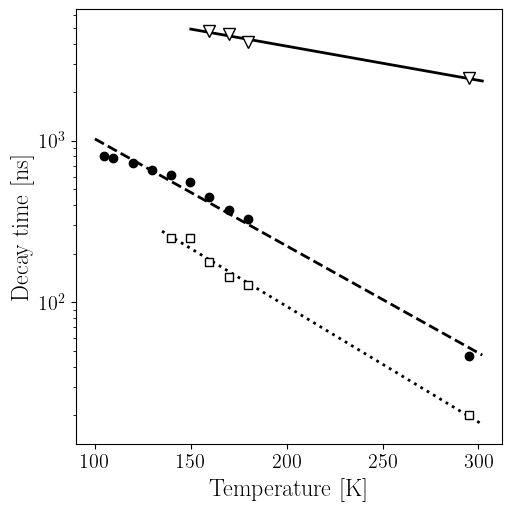

In [9]:
fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(5,5))
ax.errorbar(temps_label[:4], np.array(taus)[:4]*1e9, fmt='ko')
ax.errorbar(temps_label[4:], np.array(taus_2)*1e9, fmt='ko')
ax.errorbar(temps_label[4:], np.array(taus)[4:]*1e9, fmt='ws', markeredgecolor='k')
ax.errorbar(temps_label[6:], np.array(taus_3)*1e9, fmt='wv', markeredgecolor='k', markersize=9)

fast_times = np.array(taus)[4:]*1e9

intermediate_times = np.concatenate((np.array(taus)[:4]*1e9, np.array(taus_2)*1e9))

p_lin, pcov_lin = curve_fit(crysp.lin_fit, temps_label[4:], np.log10(fast_times))
p_lin2, pcov_lin2 = curve_fit(crysp.lin_fit, temps_label, np.log10(intermediate_times))
p_lin3, pcov_lin3 = curve_fit(crysp.lin_fit, temps_label[6:], np.log10(np.array(taus_3)*1e9))

fast_temps = np.linspace(135, 302, 2)
intermediate_temps = np.linspace(100, 302, 2)
slow_temps = np.linspace(150, 302, 2)

ax.plot(fast_temps, pow(10, crysp.lin_fit(fast_temps, *p_lin)), c='k', ls=':')
ax.plot(intermediate_temps, pow(10, crysp.lin_fit(intermediate_temps, *p_lin2)), c='k', ls='--')
ax.plot(slow_temps, pow(10, crysp.lin_fit(slow_temps, *p_lin3)), c='k')

ax.set_yscale("log")
fig.savefig("times.pdf", transparent=True)
ax.set_xlabel("Temperature [K]",fontsize='xx-large')
ax.set_ylabel("Decay time [ns]",fontsize='xx-large')
ax.tick_params(axis='both', which='major', labelsize='x-large')
fig.savefig("times.pdf", transparent=True)